# Predicting Hourly Bike Rentals

### I. Descriptive Analysis

#### First we read in the dataset, perform some basic formatting, and examine the first 5 rows.

In [959]:
#!/usr/bin/env python

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing


# Read in the "train.csv" dataset

train_df = pd.read_csv('/Users/mgiangreco/Documents/wonder/train.csv')


# Since the 'casual' and 'registered' fields are not available in the 'test.csv' 
# file for which we're making predictions, we will drop them

train_df.drop(['casual', 'registered'], axis=1, inplace=True)


# Read in the "test.csv" dataset 

test_df = pd.read_csv('/Users/mgiangreco/Documents/wonder/test.csv')


# Merge the datasets together -- the value of 'count' will be NaN for rows in test set

df = pd.concat([train_df, test_df])


# Convert 'datetime' column to Python datetime format and set to index 

df['datetime'] =  pd.to_datetime(df['datetime'])

df.set_index(['datetime'], inplace=True)


# Examine dataframe

print(df.head(5))

                      atemp  count  holiday  humidity  season  temp  weather  \
datetime                                                                       
2011-01-01 00:00:00  14.395   16.0        0        81       1  9.84        1   
2011-01-01 01:00:00  13.635   40.0        0        80       1  9.02        1   
2011-01-01 02:00:00  13.635   32.0        0        80       1  9.02        1   
2011-01-01 03:00:00  14.395   13.0        0        75       1  9.84        1   
2011-01-01 04:00:00  14.395    1.0        0        75       1  9.84        1   

                     windspeed  workingday  
datetime                                    
2011-01-01 00:00:00        0.0           0  
2011-01-01 01:00:00        0.0           0  
2011-01-01 02:00:00        0.0           0  
2011-01-01 03:00:00        0.0           0  
2011-01-01 04:00:00        0.0           0  


#### Let's take a closer look at 'count', the variable we're ultimately trying to predict.

In [960]:
df['count'].describe()

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: count, dtype: float64

#### Since the hourly counts have a high standard deviation, let's resample into daily intervals before plotting.

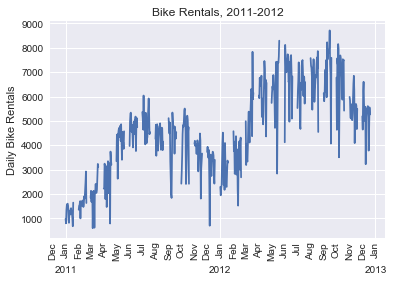

In [961]:
# Resample into daily intervals

df_daily = df.groupby(pd.Grouper(freq='D', 
                                 closed='left', 
                                 label='left'))['count'].sum()


# Visualize as a scatter plot

years = mdates.YearLocator()
months = mdates.MonthLocator()
monthsFmt = mdates.DateFormatter('%b') 
yearsFmt = mdates.DateFormatter('\n\n%Y')  
dts = df_daily.index.to_pydatetime()
rentals = df_daily.iloc[:].tolist()

fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(dts, rentals)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_locator(years)
ax.xaxis.set_major_formatter(yearsFmt)

plt.ylabel('Daily Bike Rentals')
plt.title('Bike Rentals, 2011-2012');

#### The series has an upward trend, as well as a seasonal component (more rentals in summer). Zooming in a bit, we can see that there's some interday volatility, as well as missing data at the end of each month corresponding to the values we will be predicting.

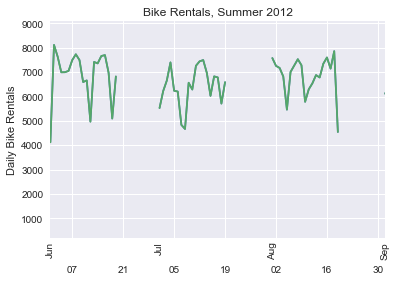

In [962]:
days = mdates.DayLocator()
daysFmt = mdates.DateFormatter('\n\n%d')


fig = plt.figure(); ax = fig.add_subplot(111)
ax.plot(dts, rentals)
ax.set_xlim([dt.date(2012, 6, 1), dt.date(2012, 9, 1)])
ax.plot(dts, rentals)
ax.xaxis.set_minor_locator(months)
ax.xaxis.set_minor_formatter(monthsFmt)
plt.setp(ax.xaxis.get_minorticklabels(), rotation=90)
ax.xaxis.set_major_formatter(daysFmt)

plt.ylabel('Daily Bike Rentals')
plt.title('Bike Rentals, Summer 2012');

#### Temperature ('temp') seems like it would have an obvious impact on bike ridership. A plot confirms an overall upward sloping trend, though it's not clear that the relationship is strictly linear.

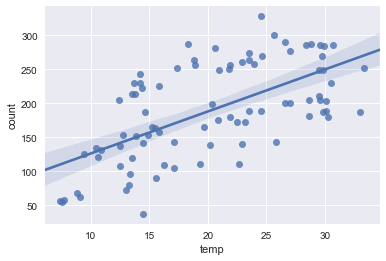

In [963]:
# Plot average hourly ridership count against temperature

df_weekly = df[['count', 'temp']].resample('W').mean()

sns.regplot(x='temp', y='count', data=df_weekly); 

### II. Feature Engineering

#### Although the dataset is technically a time series, we can add some time-based features and reframe the prediction task as a supervised learning problem. Given what we've learned about trend and seasonality, we need to create features that capture these attributes.

In [964]:
# Add a column for days since first date in dataset

df['days_since_first_date'] = (df.index.date - (df.index.date.min()))

df['days_since_first_date'] = df['days_since_first_date'].astype('timedelta64[D]').astype(int)

In [965]:
# Add dummy variables for hour of day

df['hour_of_day'] = df.index.hour

df_hod = pd.get_dummies(df['hour_of_day'], 
                        prefix='hour')

df = pd.concat([df, df_hod], axis=1)

df.drop('hour_of_day', axis=1, inplace=True)

In [966]:
# Add dummy variables for day of week

df['day_of_week'] = df.index.dayofweek

df_dow = pd.get_dummies(df['day_of_week'], 
                        prefix='dow')

df = pd.concat([df, df_dow], axis=1)

df.drop('day_of_week', axis=1, inplace=True)

In [967]:
# Add dummy variables for month of year

df['month_of_year'] = df.index.month

df_moy = pd.get_dummies(df['month_of_year'], 
                        prefix='month')

df = pd.concat([df, df_moy], axis=1)

df.drop('month_of_year', axis=1, inplace=True)

#### 'Weather' and "season" are currently incorrectly encoded as a continuous variables--let's encode them as dummy variables.

In [968]:
# One-hot-encode 'weather' and 'season' variables

df_weather = pd.get_dummies(df['weather'], 
                            prefix='weather')

df = pd.concat([df, df_weather], axis=1)

df.drop('weather', axis=1, inplace=True)


df_season = pd.get_dummies(df['season'], 
                            prefix='season')

df = pd.concat([df, df_season], axis=1)

df.drop('season', axis=1, inplace=True)

#### Here's our processed dataset.

In [969]:
print(df.columns)
print(df.head(1))

Index([u'atemp', u'count', u'holiday', u'humidity', u'temp', u'windspeed',
       u'workingday', u'days_since_first_date', u'hour_0', u'hour_1',
       u'hour_2', u'hour_3', u'hour_4', u'hour_5', u'hour_6', u'hour_7',
       u'hour_8', u'hour_9', u'hour_10', u'hour_11', u'hour_12', u'hour_13',
       u'hour_14', u'hour_15', u'hour_16', u'hour_17', u'hour_18', u'hour_19',
       u'hour_20', u'hour_21', u'hour_22', u'hour_23', u'dow_0', u'dow_1',
       u'dow_2', u'dow_3', u'dow_4', u'dow_5', u'dow_6', u'month_1',
       u'month_2', u'month_3', u'month_4', u'month_5', u'month_6', u'month_7',
       u'month_8', u'month_9', u'month_10', u'month_11', u'month_12',
       u'weather_1', u'weather_2', u'weather_3', u'weather_4', u'season_1',
       u'season_2', u'season_3', u'season_4'],
      dtype='object')
             atemp  count  holiday  humidity  temp  windspeed  workingday  \
datetime                                                                    
2011-01-01  14.395   16.0        0

### III. Model Selection

#### Before starting the modeling process, we need to reserve a holdout set from our training dataset to help us guard against overfitting.

In [970]:
# Move 'count' column to first position 

cols = list(df)
cols.insert(0, cols.pop(cols.index('count')))
df = df.loc[:, cols]


# Separate dependent from independent variables in training set

train_df_processed = df[df['count'].notnull()]

X = train_df_processed.iloc[:, 1:]
y = train_df_processed['count']


# Split into 85% train, 15% test

X_train, X_holdout, y_train, y_holdout = train_test_split(X, y, test_size=0.15, 
                                                    random_state=2017)

#### Let's start with basic OLS regression to get a baseline.

In [971]:
# Specify linear regression model

ols = LinearRegression(normalize=True)


# Fit the model to the 

ols.fit(X_train, y_train)


# Print prediction accuracy

y_train_pred = ols.predict(X_train)
y_holdout_pred = ols.predict(X_holdout)

print ('OLS| MSE train: %.3f, holdout: %.3f' % (mean_squared_error(y_train, y_train_pred), 
                                        mean_squared_error(y_holdout, y_holdout_pred)))

OLS| MSE train: 9942.880, holdout: 10647.041


#### Now we try a random forest, an algorithm that detects non-linear feature interactions. Our random forest performs better than OLS regression, suggesting that there may be some non-linearity to our data. Note that this particular random forest model appears to slightly overfit our training data.

In [972]:
# Specify random forest regression model

rfr = RandomForestRegressor(criterion='mse', 
                            n_estimators=500,
                            bootstrap=True, 
                            oob_score=False, 
                            n_jobs= -1, 
                            random_state=148) 


# Grid search to find optimal hyperparameters

param_grid = { 
    'max_depth': [None, 25, 50],
    'min_samples_leaf': [25, 50, 75]
}

CV_rfr = GridSearchCV(estimator=rfr, param_grid=param_grid, 
                      scoring='neg_mean_squared_error')
CV_rfr.fit(X_train, y_train)
print CV_rfr.best_params_

{'max_depth': None, 'min_samples_leaf': 25}


In [973]:
# Fit the optimal model to the data

rfr = CV_rfr.best_estimator_

rfr.fit(X_train, y_train)

# Print prediction accuracy
y_train_pred = rfr.predict(X_train)
y_holdout_pred = rfr.predict(X_holdout)

print ('Random Forest| MSE train: %.3f, holdout: %.3f' % (mean_squared_error(y_train, y_train_pred), 
                                        mean_squared_error(y_holdout, y_holdout_pred)))


Random Forest| MSE train: 6330.419, holdout: 7879.542


#### When we look at the random forest features, in order of importance, the list makes sense: the top-ranked features (holiday, workingday, temp) seem relevant to our problem, while the bottom-ranked features (weather, season) are likely redundant in the context of other available features.

In [974]:
importances = rfr.feature_importances_

indices = np.argsort(importances)[::-1]
feat_labels = df.columns[1:]

for f in range(X_train.shape[1]):
    print ("%2d) %-*s %f" % (f + 1, 30,
                            feat_labels[f],
                            importances[indices[f]]))

 1) atemp                          0.181495
 2) holiday                        0.161422
 3) humidity                       0.121143
 4) temp                           0.109153
 5) windspeed                      0.075891
 6) workingday                     0.073192
 7) days_since_first_date          0.061784
 8) hour_0                         0.026898
 9) hour_1                         0.017869
10) hour_2                         0.016990
11) hour_3                         0.016870
12) hour_4                         0.016752
13) hour_5                         0.016325
14) hour_6                         0.015870
15) hour_7                         0.014216
16) hour_8                         0.009914
17) hour_9                         0.009178
18) hour_10                        0.007027
19) hour_11                        0.006811
20) hour_12                        0.006639
21) hour_13                        0.004907
22) hour_14                        0.004634
23) hour_15                     

#### When we implement a gradient boosting machine, another tree-based algorithm, we get a significant improvement in performance. MSE of 3249 on the holdout set means that our model is off by about 57 rentals, on average.

In [975]:
# Specify gradient boosting regressor

est = ensemble.GradientBoostingRegressor()

# Grid search to find optimal hyperparameters

param_grid = {'learning_rate' : [0.01, 0.1],
              'n_estimators' : [100, 200],
              'max_depth' : [2, 4],
              'min_samples_leaf' : [75, 100]
              }

gs_cv = GridSearchCV(est, param_grid, n_jobs=-1).fit(X_train, y_train)


# Best hyperparameter setting

print gs_cv.best_params_

{'n_estimators': 200, 'learning_rate': 0.1, 'max_depth': 4, 'min_samples_leaf': 75}


In [976]:
# Fit the optimal model to the data

gbm = gs_cv.best_estimator_

gbm.fit(X_train, y_train)


# Print prediction accuracy

y_train_pred = gbm.predict(X_train)
y_holdout_pred = gbm.predict(X_holdout)

print ('GBM| MSE train: %.3f, holdout: %.3f' % (mean_squared_error(y_train, y_train_pred), 
                                        mean_squared_error(y_holdout, y_holdout_pred)))

GBM| MSE train: 2735.150, holdout: 3248.627


#### Finally, when we attempt a support vector machine with a Gaussian kernel we achieve even better performance on the training set, but the holdout score tells us that our chosen model likely suffers from severe overfitting, even with regularization. 

In [977]:
# Scale the data 

X_scaled = preprocessing.scale(X)


# Split into 85% train, 15% test

X_train_scaled, X_holdout_scaled, y_train, y_holdout = train_test_split(X_scaled, 
                                                                        y, test_size=0.15,
                                                                        random_state=2017)

In [978]:
# Specify support vector regressor with Gaussian kernel

svr_rbf = SVR(kernel='rbf')


# Grid search to find optimal hyperparameters

param_grid = {'C' : [10, 1000, 10000],
              'gamma' : [0.01, 0.1],
              'epsilon': [0.1, 0.5]
              }

svr_cv = GridSearchCV(svr_rbf, param_grid, n_jobs=-1).fit(X_train_scaled, y_train)


# Best hyperparameter setting

print svr_cv.best_params_

{'epsilon': 0.5, 'C': 1000, 'gamma': 0.01}


In [979]:
# Fit the optimal model to the data

svr = svr_cv.best_estimator_

svr.fit(X_train_scaled, y_train)


# Print prediction accuracy

y_train_pred = svr.predict(X_train_scaled)
y_test_pred = svr.predict(X_holdout_scaled)

print ('SVR| MSE train: %.3f, holdout: %.3f' % (mean_squared_error(y_train, y_train_pred), 
                                        mean_squared_error(y_holdout, y_holdout_pred)))

SVR| MSE train: 855.832, holdout: 3248.627


### IV. Output Predictions

#### Let's make predictions for the test dataset using the best GBM model, storing them in a file called 'preds.csv'. Some predicted values are negative, which is clearly not possible, so we can set those to zero before printing.

In [980]:
# Specify the processed test dataframe and drop the 'count' column

test_df_processed = df[df['count'].isnull()]

test_df_processed.drop(['count'], axis=1, inplace=True)


# Make the predictions

predictions = gbm.predict(test_df_processed)

test_df_processed['count'] = predictions

print(test_df_processed['count'].head(10))

datetime
2011-01-20 00:00:00    -10.358726
2011-01-20 01:00:00    -20.023940
2011-01-20 02:00:00    -33.236864
2011-01-20 03:00:00    -27.400885
2011-01-20 04:00:00    -29.233340
2011-01-20 05:00:00    -17.729666
2011-01-20 06:00:00     14.419782
2011-01-20 07:00:00    136.915201
2011-01-20 08:00:00    292.619551
2011-01-20 09:00:00     92.890567
Name: count, dtype: float64


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [981]:
# Set negative 'count' estimates to zero

test_df_processed.loc[test_df_processed['count']<0,'count'] = 0

print(test_df_processed['count'].head(10))

datetime
2011-01-20 00:00:00      0.000000
2011-01-20 01:00:00      0.000000
2011-01-20 02:00:00      0.000000
2011-01-20 03:00:00      0.000000
2011-01-20 04:00:00      0.000000
2011-01-20 05:00:00      0.000000
2011-01-20 06:00:00     14.419782
2011-01-20 07:00:00    136.915201
2011-01-20 08:00:00    292.619551
2011-01-20 09:00:00     92.890567
Name: count, dtype: float64


In [982]:
# Output to csv

test_df_processed['count'].to_csv('/Users/mgiangreco/Documents/wonder/preds.csv')